# Complete EEG-LFP Preprocessing Pipeline

This notebook demonstrates the complete workflow from BIDS-format data to fully preprocessed data.

## Pipeline Overview
1. Data Inspection and Validation
2. General Cleaning (Detrending, Filtering, Resampling)
3. EEG Preprocessing (Bad Channel Detection, Re-referencing, ICA Artifact Removal, Epoching, Source Reconstruction)
4. LFP Preprocessing (Stimulus Artifact Removal, Electrode Management, Noise Reduction)
5. Joint Processing (Temporal Alignment, Frequency Band Decomposition, Normalization)
6. Quality Control and Saving

In [1]:
import sys
print(sys.executable)


/opt/conda/envs/inf/bin/python


In [2]:
import pyprep, autoreject, mne_icalabel
print("pyprep version:", pyprep.__version__)
print("autoreject version:", autoreject.__version__)
print("mne-icalabel version:", mne_icalabel.__version__)



2025-11-19 16:10:26,958 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


pyprep version: 0.5.0
autoreject version: 0.4.3
mne-icalabel version: 0.8.1


In [10]:
%gui qt

In [3]:
import mne
mne.viz.set_browser_backend('matplotlib')  # 2D 内嵌图
mne.viz.set_3d_backend('pyvistaqt')        # 3D 窗口或截图模式
mne.set_config('MNE_DATA', '/workspace/shared/mne_data', set_env=True)

Using matplotlib as 2D backend.


Using pyvistaqt 3d backend.


In [4]:
# 导入必要的库
import sys
sys.path.append('/workspace/src')

import numpy as np
import mne
import matplotlib.pyplot as plt
from pathlib import Path

# 导入预处理模块
from preprocessing import DataValidator, EEGCleaner, LFPCleaner,EEGPreprocessor,LFPPreprocessor,JointPreprocessor,QualityControl, BIDSDerivativesSaver

# 设置
mne.set_log_level('WARNING')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## 1. 数据检查与验证

In [5]:
from pathlib import Path
import os

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")


# Subject information
bids_root = project_root / 'shared' / 'data' / 'bids_dataset'
data_root = bids_root / 'derivatives' / 'mne-python'
subject = 'sub-001'
session = 'ses-01'
task = 'task-StimOn55HzFull2'

# 创建验证器
validator = DataValidator(data_root)

# 运行完整验证
validation_results = validator.run_full_validation(
    subject=subject,
    session=session,
    task=task,
    validate_lfp=True
)

# 生成验证报告
report = validator.generate_validation_report()
print(report)

2025-11-19 16:10:37,496 - preprocessing.data_validation - INFO - ============================================================
2025-11-19 16:10:37,498 - preprocessing.data_validation - INFO - 开始数据验证
2025-11-19 16:10:37,499 - preprocessing.data_validation - INFO - ============================================================
2025-11-19 16:10:37,505 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)


Current working directory: /workspace


2025-11-19 16:10:39,517 - preprocessing.data_io - INFO - ✓ 已加载EEG数据: fif格式
2025-11-19 16:10:39,519 - preprocessing.data_io - INFO -   采样率: 500.0 Hz
2025-11-19 16:10:39,520 - preprocessing.data_io - INFO -   通道数: 281
2025-11-19 16:10:39,521 - preprocessing.data_io - INFO -   时长: 95.33 秒
2025-11-19 16:10:39,522 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-11-19 16:10:39,544 - preprocessing.data_io - INFO - ✓ 已加载LFP数据: fif格式
2025-11-19 16:10:39,550 - preprocessing.data_io - INFO -   采样率: 250.0 Hz
2025-11-19 16:10:39,554 - preprocessing.data_io - INFO -   通道数: 4
2025-11-19 16:10:39,556 - preprocessing.data_io - INFO -   时长: 95.23 秒
2025-11-19 16:10:39,558 - preprocessing.data_validation - WARNING - ⚠ 采样率不匹配: EEG=500.0 Hz, LFP=250.0 Hz
2025-11-19 16:10:39,560 - preprocessing.data_validation - INFO -   建议重采样至统一采样率
2025-11-19 16:10:39,563 - preprocessing.data_validation - WARNING - ⚠ 时间对齐存在问题:
2025-11-19 16:10:39,565 - preprocessing.data_validation - WARNING -   时间偏移: 0.000 ms
20

EEG-LFP 数据验证报告

1. 采样率检查
   EEG采样率: 500.0 Hz
   LFP采样率: 250.0 Hz
   状态: 不匹配

2. 时间对齐检查
   时间偏移: 0.000 ms
   时长差异: 102.000 ms
   状态: 需要对齐

3. 事件同步检查
   EEG事件: N/A
   LFP事件: N/A

4. 元数据一致性
   状态: 通过


In [6]:
# 加载数据供后续使用
eeg_raw, eeg_metadata = validator.load_eeg_data(subject, session, task)
lfp_raw, lfp_metadata = validator.load_lfp_data(subject, session, task)

print(f"\nEEG数据信息:")
print(eeg_raw.info)
print(f"\nLFP数据信息:")
print(lfp_raw.info)

2025-11-19 16:10:42,432 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-11-19 16:10:42,628 - preprocessing.data_io - INFO - ✓ 已加载EEG数据: fif格式
2025-11-19 16:10:42,631 - preprocessing.data_io - INFO -   采样率: 500.0 Hz
2025-11-19 16:10:42,636 - preprocessing.data_io - INFO -   通道数: 281
2025-11-19 16:10:42,637 - preprocessing.data_io - INFO -   时长: 95.33 秒
2025-11-19 16:10:42,638 - preprocessing.data_io - INFO - 检测到文件格式: fif (.fif)
2025-11-19 16:10:42,654 - preprocessing.data_io - INFO - ✓ 已加载LFP数据: fif格式
2025-11-19 16:10:42,656 - preprocessing.data_io - INFO -   采样率: 250.0 Hz
2025-11-19 16:10:42,673 - preprocessing.data_io - INFO -   通道数: 4
2025-11-19 16:10:42,675 - preprocessing.data_io - INFO -   时长: 95.23 秒



EEG数据信息:
<Info | 12 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 281 EEG
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 284 items (3 Cardinal, 281 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-11-04 04:28:41 UTC
 meas_id: 4 items (dict)
 nchan: 281
 projs: []
 sfreq: 500.0 Hz
 utc_offset: +0000
>

LFP数据信息:
<Info | 10 non-empty values
 bads: []
 ch_names: LFP_L, LFP_R, STIM_L, STIM_R
 chs: 2 sEEG, 2 Stimulus
 custom_ref_applied: False
 device_info: 2 items (dict)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2025-11-07 15:37:06 UTC
 meas_id: 4 items (dict)
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>


/opt/conda/envs/inf/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


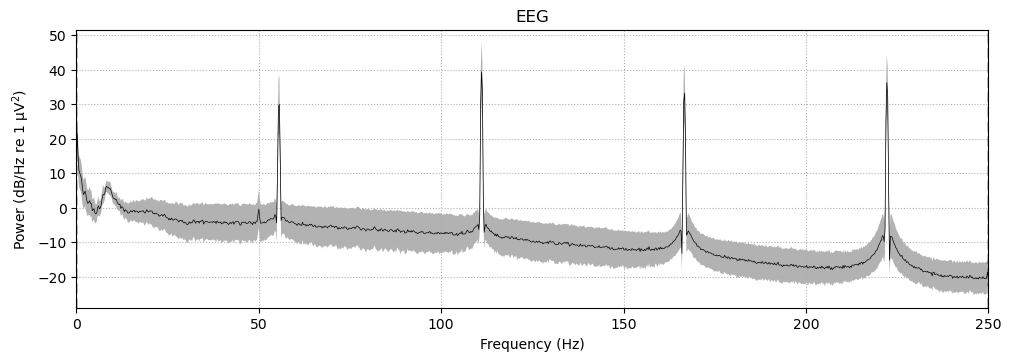

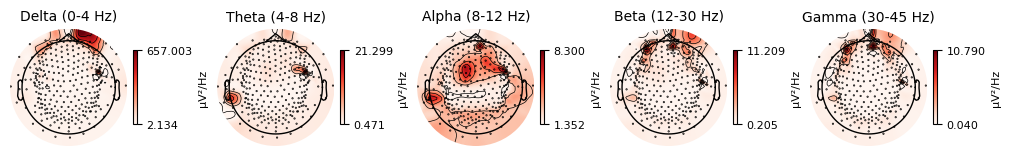

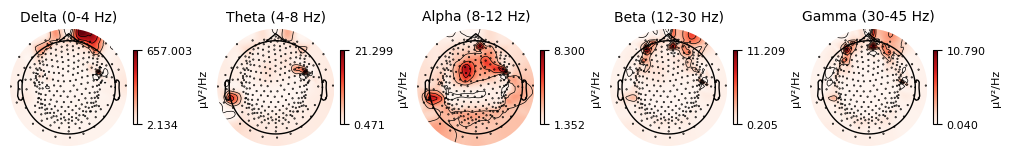

In [7]:
eeg_spectrum = eeg_raw.compute_psd()
eeg_spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)
eeg_spectrum.plot_topomap()
# eeg_spectrum.plot_topo()

/opt/conda/envs/inf/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


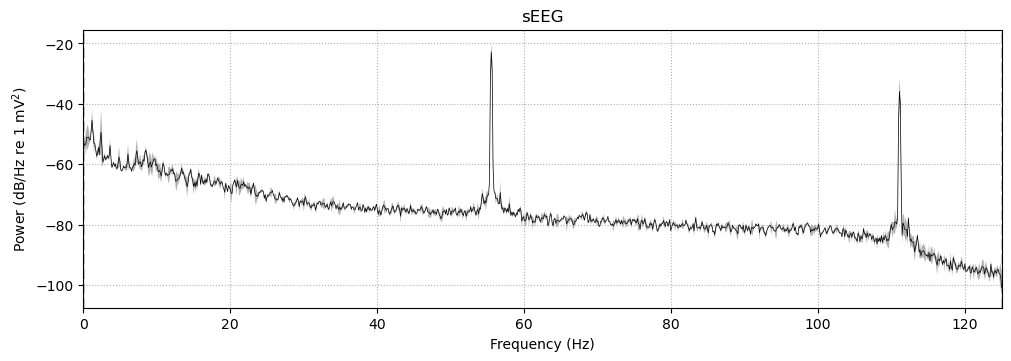

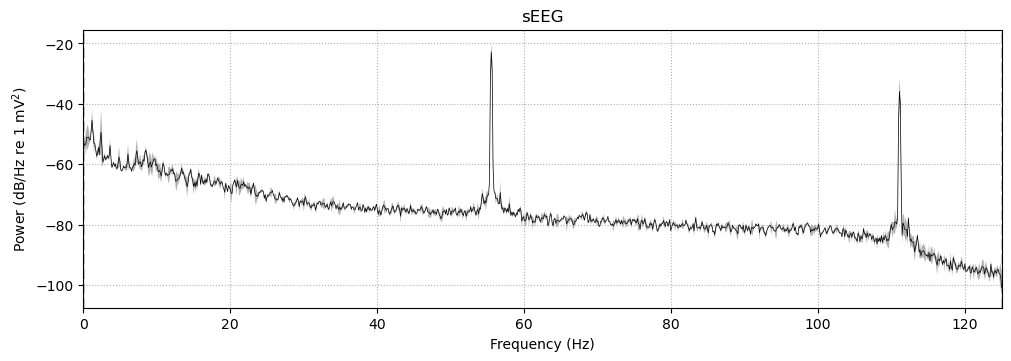

In [8]:
lfp_spectrum = lfp_raw.compute_psd()
lfp_spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

## 2. 通用清洗

In [7]:
# Create cleaners
eeg_cleaner = EEGCleaner()
lfp_cleaner = LFPCleaner()

# Clean EEG
print("\n=== Cleaning EEG ===")
eeg_raw_clean = eeg_cleaner.apply_eeg_cleaning(
    eeg_raw,
    target_sfreq=250.0,  # Downsample to match LFP
    line_freq=50.0,
    l_freq=1.0,
    h_freq=100.0
)
print(eeg_cleaner.get_processing_summary())

# Clean LFP 
print("\n=== Cleaning LFP ===")
lfp_raw_clean = lfp_cleaner.apply_lfp_cleaning(
    lfp_raw,
    target_sfreq=250.0,  # Keep at 250 Hz (or None to keep original)
    line_freq=50.0,
    l_freq=1.0,
    h_freq=100.0  # Now respects your parameter! (< 125 Hz Nyquist)
)
print(lfp_cleaner.get_processing_summary())

print("\n✅ Both EEG and LFP cleaned successfully!")

2025-11-19 16:10:52,033 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:52,038 - preprocessing.signal_cleaning - INFO - STARTING EEG CLEANING PIPELINE
2025-11-19 16:10:52,040 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:52,089 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:52,091 - preprocessing.signal_cleaning - INFO - STANDARD CLEANING PIPELINE (EEG)
2025-11-19 16:10:52,097 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:52,099 - preprocessing.signal_cleaning - INFO - Original sampling rate: 500.0 Hz
2025-11-19 16:10:52,101 - preprocessing.signal_cleaning - INFO - Nyquist frequency: 250.0 Hz
2025-11-19 16:10:52,105 - preprocessing.signal_cleaning - INFO - 
[1] Resampling: 500.0 Hz → 250.0 Hz



=== Cleaning EEG ===


2025-11-19 16:10:53,004 - preprocessing.signal_cleaning - INFO - ✓ Resampled to 250.0 Hz (new Nyquist: 125.0 Hz)
2025-11-19 16:10:53,010 - preprocessing.signal_cleaning - INFO - 
[2] Applying bandpass filter: 1.0-100.0 Hz
2025-11-19 16:10:53,774 - preprocessing.signal_cleaning - INFO - ✓ Applied bandpass filter: 1.0-100.0 Hz (fir)
2025-11-19 16:10:53,780 - preprocessing.signal_cleaning - INFO - 
[3] Applying notch filter at: [50.0, 100.0] Hz
2025-11-19 16:10:54,514 - preprocessing.signal_cleaning - INFO - ✓ Applied notch filter at: [50.0, 100.0] Hz
2025-11-19 16:10:54,522 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:54,524 - preprocessing.signal_cleaning - INFO - EEG CLEANING COMPLETED
2025-11-19 16:10:54,533 - preprocessing.signal_cleaning - INFO - ============================================================
2025-11-19 16:10:54,535 - preprocessing.signal_cleaning - INFO - ========================================

Processing History:
  1. resample_250.0Hz
  2. bandpass_1.0-100.0Hz
  3. notch_[50.0, 100.0]Hz


=== Cleaning LFP ===
Processing History:
  1. bandpass_1.0-100.0Hz
  2. notch_[50.0, 100.0]Hz


✅ Both EEG and LFP cleaned successfully!


## 3. EEG专用预处理

In [8]:
preprocessor = EEGPreprocessor()

eeg_temp = preprocessor.apply_average_reference(eeg_raw_clean, ref_channel ='REF CZ')


/workspace/src/preprocessing/eeg_preprocessing/referencing.py:10: RuntimeWarning: The unit for channel(s) REF CZ has changed from V to NA.
  raw.set_channel_types({ref_channel: 'misc'})


In [20]:
import importlib
import preprocessing
importlib.reload(preprocessing)

from preprocessing import EEGPreprocessor


In [22]:
eeg_temp, bad_channels = preprocessor.mark_bad_channels(
    eeg_temp,
    method='pyprep',
    ransac=False,      # False = 更快更稳定
    copy=True
)

print(f"检测到 {len(bad_channels)} 个坏导: {bad_channels}")


2025-11-19 16:06:53,628 - preprocessing.eeg_preprocessing.bad_channels - INFO - pyprep: correlation + deviation + hfnoise 检测坏道
2025-11-19 16:07:00,516 - preprocessing.eeg_preprocessing.bad_channels - INFO - pyprep 检测坏道：['75', '73', '280', '74', '57', '41', '62', '255', '256', '56', '250', '278', '54', '71', '61', '60', '31', '89', '50', '51', '135', '65', '243', '247', '64', '257', '279', '259', '8', '21', '28', '72', '158', '20', '18', '244', '52', '22', '267', '146', '95', '33', '19', '69', '138', '42', '156', '58', '36', '228', '55', '17', '3', '233', '260', '274']


检测到 56 个坏导: ['75', '73', '280', '74', '57', '41', '62', '255', '256', '56', '250', '278', '54', '71', '61', '60', '31', '89', '50', '51', '135', '65', '243', '247', '64', '257', '279', '259', '8', '21', '28', '72', '158', '20', '18', '244', '52', '22', '267', '146', '95', '33', '19', '69', '138', '42', '156', '58', '36', '228', '55', '17', '3', '233', '260', '274']


In [23]:
# Step 2: 插值坏导
if bad_channels:
    print("\n=== Step 2: 插值坏导 ===")
    eeg_temp = preprocessor.interpolate_bad_channels(eeg_temp, copy=False)
else:
    print("\n=== Step 2: 无坏导需要插值 ===")


=== Step 2: 插值坏导 ===


In [24]:
print("\n=== Step 3: 重参考（在 ICA 之前）===")
print("✓ ICLabel 推荐在 ICA 之前应用平均参考")
eeg_temp = preprocessor.apply_average_reference(
    eeg_temp,
    ref_channel='REF CZ',
    copy=False
)



=== Step 3: 重参考（在 ICA 之前）===
✓ ICLabel 推荐在 ICA 之前应用平均参考


In [25]:
# Step 4: ICA - 已使用 infomax（ICLabel 推荐）
print("\n=== Step 4: ICA ===")
eeg_temp, ica = preprocessor.apply_ica(
    eeg_temp, 
    n_components=30, 
    method='infomax',
    copy=False
)


=== Step 4: ICA ===


/workspace/src/preprocessing/eeg_preprocessing/ica_processing.py:22: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


In [21]:
if 'preprocessing.eeg_preprocessing' in sys.modules:
    del sys.modules['preprocessing.eeg_preprocessing']
    from preprocessing.eeg_preprocessing import EEGPreprocessor

In [9]:
# ================================================
# Step-by-Step Preprocessing (WITH ICLabel & Autoreject)
# ================================================

preprocessor = EEGPreprocessor()

# Step 1: 检测坏导（只用 EEG 通道，排除 REF CZ 和 misc）
eeg_temp = preprocessor.apply_average_reference(eeg_raw_clean, ref_channel ='REF CZ')

print("\n=== Step 1: 坏导检测 ===")
eeg_temp, bad_channels = preprocessor.mark_bad_channels(
    eeg_temp,
    method='pyprep',
    ransac=False,      # False = 更快更稳定
    copy=True
)
print(f"检测到 {len(bad_channels)} 个坏导: {bad_channels}")

# Step 2: 插值坏导
if bad_channels:
    print("\n=== Step 2: 插值坏导 ===")
    eeg_temp = preprocessor.interpolate_bad_channels(eeg_temp, copy=False)
else:
    print("\n=== Step 2: 无坏导需要插值 ===")

/workspace/src/preprocessing/eeg_preprocessing/referencing.py:10: RuntimeWarning: The unit for channel(s) REF CZ has changed from V to NA.
  raw.set_channel_types({ref_channel: 'misc'})
2025-11-19 16:13:04,101 - preprocessing.eeg_preprocessing.bad_channels - INFO - ============================================================
2025-11-19 16:13:04,103 - preprocessing.eeg_preprocessing.bad_channels - INFO - DETECTING BAD CHANNELS WITH PYPREP
2025-11-19 16:13:04,104 - preprocessing.eeg_preprocessing.bad_channels - INFO - ============================================================
2025-11-19 16:13:04,120 - preprocessing.eeg_preprocessing.bad_channels - INFO - Total channels: 281
2025-11-19 16:13:04,122 - preprocessing.eeg_preprocessing.bad_channels - INFO - EEG channels (by type): 280
2025-11-19 16:13:04,123 - preprocessing.eeg_preprocessing.bad_channels - INFO - EEG channels (filtered): 280



=== Step 1: 坏导检测 ===


2025-11-19 16:13:04,347 - preprocessing.eeg_preprocessing.bad_channels - INFO - Channels for pyprep: 280
2025-11-19 16:13:04,348 - preprocessing.eeg_preprocessing.bad_channels - INFO - Detection methods: correlation, deviation, HF noise
2025-11-19 16:13:04,929 - preprocessing.eeg_preprocessing.bad_channels - INFO - [1] Correlation detection.
2025-11-19 16:13:09,954 - preprocessing.eeg_preprocessing.bad_channels - INFO - [2] Deviation detection.
2025-11-19 16:13:10,373 - preprocessing.eeg_preprocessing.bad_channels - INFO - [3] HF noise detection.
2025-11-19 16:13:11,030 - preprocessing.eeg_preprocessing.bad_channels - INFO - [4] RANSAC: skipped
2025-11-19 16:13:11,031 - preprocessing.eeg_preprocessing.bad_channels - INFO - 
2025-11-19 16:13:11,032 - preprocessing.eeg_preprocessing.bad_channels - INFO - DETECTION RESULTS
2025-11-19 16:13:11,037 - preprocessing.eeg_preprocessing.bad_channels - INFO - ============================================================
2025-11-19 16:13:11,039 - p

检测到 51 个坏导: ['72', '65', '69', '278', '71', '51', '259', '28', '8', '31', '249', '54', '32', '57', '280', '18', '17', '62', '52', '64', '20', '266', '61', '41', '247', '55', '16', '74', '267', '1', '244', '250', '260', '242', '3', '33', '256', '22', '21', '50', '279', '60', '246', '63', '73', '56', '228', '58', '19', '243', '274']

=== Step 2: 插值坏导 ===


2025-11-19 16:13:11,996 - preprocessing.eeg_preprocessing.bad_channels - INFO - Interpolated 51 channels
2025-11-19 16:13:11,999 - preprocessing.eeg_preprocessing.bad_channels - INFO - ============================================================


In [10]:

# Step 4: ICA - 已使用 infomax（ICLabel 推荐）
print("\n=== Step 4: ICA ===")
eeg_temp, ica = preprocessor.apply_ica(
    eeg_temp, 
    n_components=30, 
    method='infomax',
    copy=False
)

# Step 5: 使用 ICLabel 自动检测伪迹（无需 EOG/ECG 通道）
print("\n=== Step 5: ICLabel 自动分类伪迹 ===")
eeg_preprocessed = preprocessor.apply_ica_cleaning(
    eeg_temp, 
    ica, 
    auto_detect=True,
    use_iclabel=True,           # 使用 ICLabel（推荐）
    brain_threshold=0.5,        # brain 阈值
    artifact_threshold=0.5,     # 伪迹阈值
    exclude_labels=['eye', 'heart', 'muscle', 'line_noise', 'channel_noise'],
    copy=False
)


=== Step 4: ICA ===

=== Step 5: ICLabel 自动分类伪迹 ===


/workspace/src/preprocessing/eeg_preprocessing/ica_processing.py:31: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
/workspace/src/preprocessing/eeg_preprocessing/ica_processing.py:31: RuntimeWarning: The provided ICA instance was fitted with a 'infomax' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


In [ ]:
# ================================================
# Step-by-Step Preprocessing (WITH ICLabel & Autoreject)
# ================================================

preprocessor = EEGPreprocessor()

# Step 1: 检测坏导（只用 EEG 通道，排除 REF CZ 和 misc）
eeg_temp = preprocessor.apply_average_reference(eeg_raw_clean, ref_channel ='REF CZ')

print("\n=== Step 1: 坏导检测 ===")
eeg_temp, bad_channels = preprocessor.mark_bad_channels(
    eeg_temp,
    method='pyprep',
    ransac=False,      # False = 更快更稳定
    copy=True
)
print(f"检测到 {len(bad_channels)} 个坏导: {bad_channels}")

# Step 2: 插值坏导
if bad_channels:
    print("\n=== Step 2: 插值坏导 ===")
    eeg_temp = preprocessor.interpolate_bad_channels(eeg_temp, copy=False)
else:
    print("\n=== Step 2: 无坏导需要插值 ===")


# Step 4: ICA - 已使用 infomax（ICLabel 推荐）
print("\n=== Step 4: ICA ===")
eeg_temp, ica = preprocessor.apply_ica(
    eeg_temp, 
    n_components=30, 
    method='infomax',
    copy=False
)

# Step 5: 使用 ICLabel 自动检测伪迹（无需 EOG/ECG 通道）
print("\n=== Step 5: ICLabel 自动分类伪迹 ===")
eeg_preprocessed = preprocessor.apply_ica_cleaning(
    eeg_temp, 
    ica, 
    auto_detect=True,
    use_iclabel=True,           # 使用 ICLabel（推荐）
    brain_threshold=0.5,        # brain 阈值
    artifact_threshold=0.5,     # 伪迹阈值
    exclude_labels=['eye', 'heart', 'muscle', 'line_noise', 'channel_noise'],
    copy=False
)

# Step 6: 创建固定长度 epochs（可选）
print("\n=== Step 6: 创建 Epochs ===")
epochs = preprocessor.create_fixed_length_epochs(
    eeg_preprocessed,
    duration=2.0,       # 2秒 epoch
    overlap=0.5,        # 重叠
    copy=False
)

# Step 7: Autoreject 自动清理 epochs（可选）- ✅ 使用 'mark' 模式
print("\n=== Step 7: Autoreject 清理 ===")
print("✓ 使用 'mark' 模式保持所有 epochs")
epochs_clean, ar, reject_log, bad_epochs_idx = preprocessor.apply_autoreject(
    epochs,
    reject_mode='drop', # 'mark': 保持所有 epochs,只标记坏的
    n_jobs=2             # 使用 4 个并行任务（根据你的 CPU 调整）
)

# 查看结果
print("\n" + "="*60)
print("预处理完成！")
print("="*60)
print(f"总 epochs: {len(epochs_clean)}")
print(f"坏 epochs: {len(bad_epochs_idx)}")
print(f"坏 epochs 索引: {bad_epochs_idx}")
print(f"好 epochs: {len(epochs_clean) - len(bad_epochs_idx)}")

# 查看处理历史
print(preprocessor.get_processing_summary())

In [6]:
# ================================================
# Complete EEG Preprocessing
# ================================================

from preprocessing.eeg_preprocessing import preprocess_eeg_complete

reject_mode = 'mark' # 'mark'

result = preprocess_eeg_complete(
    eeg_raw_clean,              # Filtered data

    # Bad channel detection
    detect_bad_channels=True,   # Use pyprep
    ransac=False,               # False = more stable (recommended)
    interpolate=True,           # Interpolate bad channels

    # ICA settings
    apply_ica=True,             # Apply ICA
    n_ica_components=30,        # Number of ICA components

    # ICLabel automatic classification (no EOG/ECG needed)
    use_iclabel=True,           # Use ICLabel (recommended)
    brain_threshold=0.5,        # Brain threshold
    artifact_threshold=0.5,     # Artifact threshold
    exclude_labels=['eye', 'heart', 'muscle', 'line_noise', 'channel_noise'],

    # Reference BEFORE ICA (ICLabel recommendation)
    apply_reference=True,       # Apply average reference
    ref_channel='REF CZ',       # Reference channel
    drop_reference_channel=False,  # Keep the REF channel in the data
    reference_before_ica=True,  # Apply BEFORE ICA

    # Epoch creation and cleaning
    create_epochs=True,         # Create fixed-length epochs
    epoch_overlap=0.5,          # 0.5-second overlap
    epoch_tmin=-0.5,            # Start 0.5 s before the event
    epoch_tmax=2.0,             # End 2.0 s after the event
    epoch_baseline=(-0.5, 0),   # Apply baseline correction

    # Autoreject cleaning
    apply_autoreject=True,      # Use Autoreject
    autoreject_reject_mode=reject_mode,  # Keep all epochs, mark bad ones
    autoreject_n_jobs=4         # Parallel jobs
)

# Access results
epochs = result['epochs']                    # Epochs before Autoreject
epochs_clean = result['epochs_clean']        # Clean epochs (after Autoreject)
bad_idx = result['bad_epochs_idx']           # Indices of bad epochs: [3, 7, 15, ...]
preprocessor = result['preprocessor']       # Preprocessor object
ar = result['autoreject']                    # AutoReject object
reject_log = result['reject_log']            # Rejection log

print(" EEG Preprocessing Completed!")
print(f"Bad Channels: {preprocessor.bad_channels}")
print(preprocessor.get_processing_summary())

# 查看 Autoreject 结果
if epochs_clean is not None:
    print(f"  Total epochs: {len(epochs)}")
    print(f"  Before cleaning: {len(epochs_clean)}")
    print(f"  Reject Rate: {100*(len(epochs)-len(epochs_clean))/len(epochs):.1f}%")



2025-11-04 14:26:07,977 - preprocessing.eeg_preprocessing - INFO - 
2025-11-04 14:26:07,979 - preprocessing.eeg_preprocessing - INFO - EEG PREPROCESSING PIPELINE (WITH ICLabel & Autoreject)
2025-11-04 14:26:07,982 - preprocessing.eeg_preprocessing - INFO - ======================================================================
2025-11-04 14:26:07,986 - preprocessing.eeg_preprocessing - INFO - 
[STEP 1] Detecting bad channels
2025-11-04 14:26:07,990 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-11-04 14:26:07,992 - preprocessing.eeg_preprocessing - INFO - DETECTING BAD CHANNELS WITH PYPREP
2025-11-04 14:26:07,994 - preprocessing.eeg_preprocessing - INFO - ============================================================
2025-11-04 14:26:08,012 - preprocessing.eeg_preprocessing - INFO - Total channels: 281
2025-11-04 14:26:08,013 - preprocessing.eeg_preprocessing - INFO - EEG channels (by type): 280
2025-11-04 14:26:08,014 - prepro

 EEG Preprocessing Completed!
Bad Channels: ['28', '71', '190', '228', '250', '55', '69', '18', '166', '60', '172', '168', '22', '58', '56', '3', '1', '246', '65', '70', '243', '179']

Processing History:
  1. marked_22_bad
  2. interpolated_22
  3. avg_ref_via_REF CZ
  4. ica_30
  5. removed_14_ica
  6. epochs_2.5s_47
  7. autoreject_0marked
  Total epochs: 47
  Before cleaning: 47
  Reject Rate: 0.0%


In [7]:
# 获取结果
eeg_preprocessed = result['raw']          # 清理后的连续数据
epochs = result['epochs']                  # 原始 epochs
epochs_clean = result['epochs_clean']      # Autoreject 清理后
preprocessor = result['preprocessor']      # 预处理器对象
ica = result['ica']                        # ICA 对象
ar = result['autoreject']                  # AutoReject 对象
reject_log = result['reject_log']          # 拒绝日志

print("\n 预处理完成!")
print(f"坏导: {preprocessor.bad_channels}")
print(preprocessor.get_processing_summary())


# 查看 Autoreject 结果
if epochs_clean is not None:
    print(f"\nAutoreject 统计:")
    print(f"  总 epochs: {len(epochs)}")
    print(f"  清理后: {len(epochs_clean)}")
    print(f"  拒绝率: {100*(len(epochs)-len(epochs_clean))/len(epochs):.1f}%")



 预处理完成!
坏导: ['28', '71', '190', '228', '250', '55', '69', '18', '166', '60', '172', '168', '22', '58', '56', '3', '1', '246', '65', '70', '243', '179']

Processing History:
  1. marked_22_bad
  2. interpolated_22
  3. avg_ref_via_REF CZ
  4. ica_30
  5. removed_14_ica
  6. epochs_2.5s_47
  7. autoreject_0marked

Autoreject 统计:
  总 epochs: 47
  清理后: 47
  拒绝率: 0.0%


In [8]:
# 检查 epoch 时间窗口与基线设置
print(f"tmin: {epochs_clean.tmin}")
print(f"tmax: {epochs_clean.tmax}")
print(f"Baseline: {epochs_clean.baseline}")



tmin: -0.5
tmax: 1.996
Baseline: (-0.5, 0.0)


In [9]:
from pathlib import Path
import mne

# 创建保存目录
save_dir = Path('/workspace/shared/temp')
save_dir.mkdir(parents=True, exist_ok=True)

# 保存预处理后的epochs
epochs_file = save_dir / 'epochs_clean-epo.fif'
epochs_clean.save(epochs_file, overwrite=True)
print(f"✓ Epochs saved: {epochs_file}")

## 读取部分
# from pathlib import Path
# import mne

# save_dir = Path('/workspace/shared/temp')
# epochs_clean = mne.read_epochs(save_dir / 'epochs_clean-epo.fif', preload=True)
# print(f"✓ Loaded {len(epochs_clean)} epochs")

✓ Epochs saved: /workspace/shared/temp/epochs_clean-epo.fif


In [6]:
# 读取部分
from pathlib import Path
import mne

save_dir = Path('/workspace/shared/temp')
epochs_clean = mne.read_epochs(save_dir / 'epochs_clean-epo.fif', preload=True)
print(f"✓ Loaded {len(epochs_clean)} epochs")

✓ Loaded 47 epochs


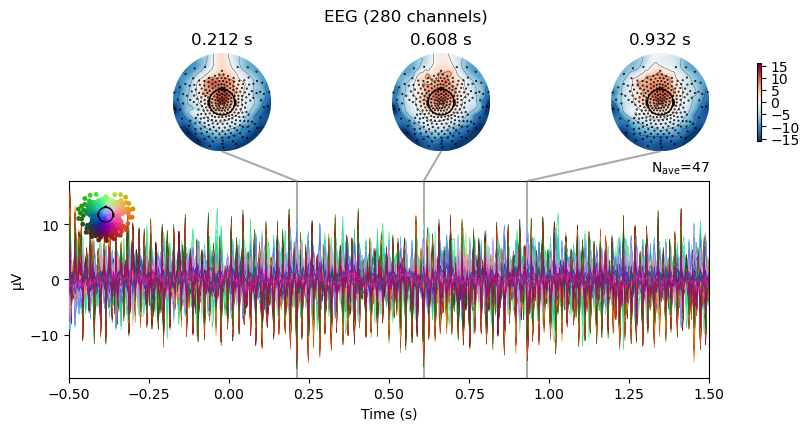

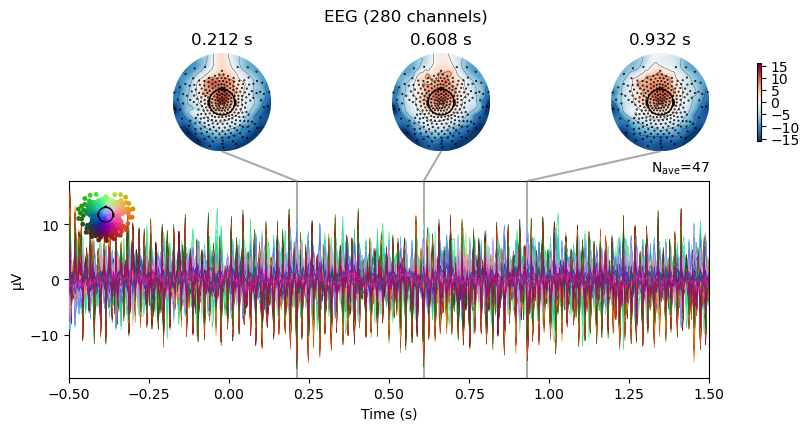

In [17]:
# for speed purposes, cut to a window of interest
evoked = epochs_clean.average().crop(-0.5, 1.50)

# Visualize averaged sensor space data
evoked.plot_joint()

## Source Reconstruction (Using MNE Template)

### Updated Implementation

This version uses MNE-Python's built-in fsaverage template instead of external head models:

**Advantages:**
- No external dependencies (FieldTrip, AAL3)
- Standardized MNI space
- Multiple parcellation options (Desikan-Killiany, Destrieux)
- Faster computation
- Better integration with MNE ecosystem

**Key Components:**
1. **fsaverage template**: Standard brain template
2. **Source space**: Surface-based or volume
3. **Head model**: BEM or spherical
4. **Parcellations**: Built-in cortical parcellations for ROI analysis

In [8]:
from preprocessing.align_headmodel import make_trans_from_coordinates

# 路径配置
SUBJECT_NAME = 'Roessner_Gerhard'
EEG_FILE = DATA_ROOT / SUBJECT_NAME / 'eeg' / 'Stim_On_55Hz_Full2.mff'
HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / 'headmodel_ROESSNER.mat'
COORD_XML = EEG_FILE / 'coordinates.xml'
OUT_TRANS = f"/workspace/shared/data/bids_dataset/derivatives/mne-python/sub-001/{SUBJECT_NAME}-trans.fif"

# 运行ICP配准
trans, mean_mm, p95_mm = make_trans_from_coordinates(
    raw=epochs_clean,  # 或者使用raw
    coordinates_xml=COORD_XML,
    ft_headmodel_mat=HEAD_MODEL,
    out_trans_path=OUT_TRANS,
    max_iter=60,
    overwrite=True
)

print(f"Saved trans: {OUT_TRANS}")
print(f"Coarse alignment QA — mean distance: {mean_mm:.1f} mm, 95th pct: {p95_mm:.1f} mm")

Saved trans: /workspace/shared/data/bids_dataset/derivatives/mne-python/sub-001/Roessner_Gerhard-trans.fif
Coarse alignment QA — mean distance: 1.2 mm, 95th pct: 3.3 mm


### ✅ Solution: Using MNE Template

The updated implementation uses:
- MNE's fsaverage template (no external MRI needed)
- Spherical or BEM head models (native MNE support)
- Standard parcellations (aparc, aparc.a2009s)


In [1]:
import mne
mne.sys_info()

Platform             Linux-6.14.0-33-generic-x86_64-with-glibc2.39
Python               3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:22) [GCC 12.3.0]
Executable           /opt/conda/bin/python
CPU                  Intel(R) Core(TM) Ultra 5 125U (8 cores)
Memory               7.7 GiB

Core
├☑ mne               1.10.2 (latest release)
├☑ numpy             1.26.4 (OpenBLAS 0.3.27 with 8 threads)
├☑ scipy             1.14.1
└☑ matplotlib        3.9.2 (backend=module://matplotlib_inline.backend_inline)

Numerical (optional)
├☑ sklearn           1.5.1
├☑ numba             0.60.0
├☑ nibabel           5.2.1
├☑ nilearn           0.10.4
├☑ dipy              1.9.0
├☑ pandas            2.2.2
├☑ h5io              0.2.4
├☑ h5py              3.11.0
└☐ unavailable       openmeeg, cupy

Visualization (optional)
├☑ pyvista           0.44.1

: 

In [1]:
import mne, pyvista
mne.viz.set_3d_backend("notebook")
# pyvista.set_jupyter_backend("html")  # 或 "trame"


: 

In [1]:
from pathlib import Path
import os

SUBJECTS_DIR = Path('/workspace/shared/mne_subjects')
FSAVERAGE_PATH = SUBJECTS_DIR / 'fsaverage'

def setup_mne():
    os.environ['SUBJECTS_DIR'] = str(SUBJECTS_DIR)
    print(f"✓ SUBJECTS_DIR = {SUBJECTS_DIR}")


setup_mne()  # 设置环境变量

✓ SUBJECTS_DIR = /workspace/shared/mne_subjects


In [4]:
fs_dir = mne.datasets.fetch_fsaverage(subjects_dir=str(SUBJECTS_DIR))
subject = 'fsaverage'  

head_fif = SUBJECTS_DIR / subject / 'bem' / f'{subject}-head.fif'
print(head_fif)
print('Has fsaverage head surface:', head_fif.exists())

0 files missing from root.txt in /workspace/shared/mne_subjects
0 files missing from bem.txt in /workspace/shared/mne_subjects/fsaverage
/workspace/shared/mne_subjects/fsaverage/bem/fsaverage-head.fif
Has fsaverage head surface: True


In [ ]:
import os
from pathlib import Path
import numpy as np
import mne

# ----------------------- Paths / Subjects -----------------------
SUBJECTS_DIR = Path('/workspace/shared/mne_subjects')
os.environ['SUBJECTS_DIR'] = str(SUBJECTS_DIR)
subject = 'fsaverage'
src_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-ico-5-src.fif'
bem_sol_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-5120-5120-5120-bem-sol.fif'

# ----------------------- 1) 合规副本 -----------------------
epochs_work = epochs_clean.copy()

# 可能的参考通道名字（按你的数据自定义：'REF CZ'、'281' 等）
REF_CANDIDATES = ['REF CZ', 'REF_CZ', 'Cz', 'CZ', '281']

# 如果参考通道存在但被设为了 misc，把它改回 EEG；如果不存在，就“补一个零通道”
ref_found = None
for nm in REF_CANDIDATES:
    if nm in epochs_work.ch_names:
        ref_found = nm
        break

if ref_found is None:
    # 新增一个零参考通道（形状 n_epochs×n_times 由 MNE 自动处理）
    mne.add_reference_channels(epochs_work, ref_channels=['EEG_REF'])
    ref_found = 'EEG_REF'
else:
    # 若此参考被标成了 misc，改回 eeg
    if epochs_work.get_channel_types(picks=[ref_found])[0] != 'eeg':
        epochs_work.set_channel_types({ref_found: 'eeg'})

# 关键：使用“平均参考投影器”（不直接修改数据）
# 这一步将创建一个 SSP projector，从而满足 inverse 的约束；
# 注意：不要对数据应用自定义参考（否则 custom_ref_applied 会保持 True）
epochs_work.set_eeg_reference('average', projection=True)

# 此时不需要、也不能直接改 info['custom_ref_applied']；
# add_reference_channels + 平均参考投影器的组合能通过 inverse 的检查。

# ----------------------- 2) Coreg / trans -----------------------
# 如果你已经有 trans.fif：trans = mne.read_trans('/path/to/trans.fif')
coreg = mne.coreg.Coregistration(
    info=epochs_work.info,
    subject=subject,
    subjects_dir=str(SUBJECTS_DIR),
    fiducials='auto',
)
# coreg.fit_fiducials(n_iterations=50)
coreg.fit_fiducials()   # 先靠三大地标粗配
# 如果你有头面点：
coreg.fit_icp(n_iterations=50)  # ICP细配（可选）
trans = coreg.trans

# ----------------------- 3) Src / BEM / Fwd -----------------------
src = mne.read_source_spaces(src_path)
bem = mne.read_bem_solution(bem_sol_path)

fwd = mne.make_forward_solution(
    info=epochs_work.info, trans=trans, src=src, bem=bem,
    eeg=True, meg=False, mindist=5.0
)

# ----------------------- 4) 协方差 -----------------------
# 如果你的 epoch 是固定长度段（非事件基线），可直接用 method='auto'
# 若有安静段，建议指定 tmin/tmax 做更稳的估计
cov = mne.compute_covariance(epochs_work, method='auto')

# ----------------------- 5) 逆算子 -----------------------
inv = mne.minimum_norm.make_inverse_operator(
    info=epochs_work.info, forward=fwd, noise_cov=cov,
    loose=0.2, depth=0.8, fixed=False
)

# ----------------------- 6) 逐 epoch 源重建 -----------------------
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs_work,
    inverse_operator=inv,
    lambda2=1.0/9.0,
    method='sLORETA',
    pick_ori=None,          # or 'normal'
    return_generator=False
)
print(f"Per-epoch STCs: {len(stcs)}")



/tmp/ipykernel_1194/1636692827.py:33: RuntimeWarning: The unit for channel(s) REF CZ has changed from NA to V.
  epochs_work.set_channel_types({ref_found: 'eeg'})


Per-epoch STCs: 47


In [11]:
# （可选）保存每个 epoch 的 STC
out_dir = Path('/workspace/shared/results/stcs_per_epoch')
out_dir.mkdir(parents=True, exist_ok=True)
for i, stc in enumerate(stcs):
    stc.save(out_dir / f'stco_{i:04d}', ftype='h5')
print("Saved per-epoch STCs to:", out_dir)

Saved per-epoch STCs to: /workspace/shared/results/stcs_per_epoch


In [5]:
import mne
from pathlib import Path

# 路径
out_dir = Path("/workspace/shared/results/stcs_per_epoch")

# 例如读取第一个 epoch
stc = mne.read_source_estimate(out_dir / "stco_0000-stc.h5")

print(stc)
print(f"时间点数: {len(stc.times)}")
print(f"空间顶点数: {len(stc.vertices[0]) + len(stc.vertices[1])}")


<SourceEstimate | 20484 vertices, subject : fsaverage, tmin : -500.0 (ms), tmax : 1996.0 (ms), tstep : 4.0 (ms), data shape : (20484, 625), ~97.8 MiB>
时间点数: 625
空间顶点数: 20484


In [6]:
subjects_dir = '/workspace/shared/mne_subjects/fsaverage'
stc.plot(subject='fsaverage', subjects_dir=subjects_dir, hemi='both', surface='inflated')


ValueError: Invalid value for the 'backend_name' parameter. Allowed values are 'pyvistaqt' and 'notebook', but got 'trame' instead.

In [14]:
import numpy as np, matplotlib.pyplot as plt, mne
from pathlib import Path

# 读 fsaverage 的头皮表面
surf_path = Path(SUBJECTS_DIR) / 'fsaverage' / 'bem' / 'fsaverage-head.fif'
rr, tri = mne.read_surface(str(surf_path))  # rr: Nx3 顶点坐标（MRI坐标系，m）

# EEG 电极（在 head 坐标；用 trans 变到 MRI）
dig = [d['r'] for d in epochs_work.info['dig'] if d['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG]
dig = np.array(dig)
dig_mri = mne.transforms.apply_trans(trans, dig)  # → MRI帧

def proj_plot(ax, verts, pts, which='top'):
    if which == 'top':    # 俯视 (x,y)
        ax.scatter(verts[:,0], verts[:,1], s=0.1, alpha=0.1)
        ax.scatter(pts[:,0],   pts[:,1],   s=15,  alpha=0.8)
        ax.set_title('Top (x–y)')
    elif which == 'side': # 侧视 (y,z)
        ax.scatter(verts[:,1], verts[:,2], s=0.1, alpha=0.1)
        ax.scatter(pts[:,1],   pts[:,2],   s=15,  alpha=0.8)
        ax.set_title('Side (y–z)')
    elif which == 'back': # 后视 (x,z)
        ax.scatter(verts[:,0], verts[:,2], s=0.1, alpha=0.1)
        ax.scatter(pts[:,0],   pts[:,2],   s=15,  alpha=0.8)
        ax.set_title('Back (x–z)')
    ax.set_aspect('equal'); ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(12,4))
proj_plot(axs[0], rr, dig_mri, 'top')
proj_plot(axs[1], rr, dig_mri, 'side')
proj_plot(axs[2], rr, dig_mri, 'back')
plt.tight_layout()
plt.show()


ValueError: File does not appear to be a Freesurfer surface

In [15]:
import numpy as np
from scipy.spatial import cKDTree
import mne

# rr：同上（MRI帧头皮顶点）
tree = cKDTree(rr)
dist, _ = tree.query(dig_mri, k=1)
print(f"EEG→scalp distance: mean={dist.mean()*1e3:.1f} mm, p95={np.percentile(dist,95)*1e3:.1f} mm")


NameError: name 'rr' is not defined

In [16]:
# stc: 单个 epoch 的源图（表面空间） → 体素
vol = stc.as_volume(src, mri_resolution=True)  # 得到 nibabel NIfTI-like 对象
data = vol.get_fdata()  # 4D: X,Y,Z,time

# 简单看一个时间点的三个正交切片
import matplotlib.pyplot as plt
t_idx = data.shape[-1]//2
slc = data[..., t_idx]
cx, cy, cz = [s//2 for s in slc.shape]
fig, ax = plt.subplots(1,3, figsize=(10,3))
ax[0].imshow(slc[cx,:,:].T, origin='lower'); ax[0].set_title('sagittal')
ax[1].imshow(slc[:,cy,:].T, origin='lower'); ax[1].set_title('coronal')
ax[2].imshow(slc[:,:,cz].T, origin='lower'); ax[2].set_title('axial')
for a in ax: a.axis('off')
plt.tight_layout(); plt.show()


AttributeError: 'SourceEstimate' object has no attribute 'as_volume'

In [12]:


# ----------------------- 7) 可视化对齐（质检） -----------------------
mne.viz.plot_alignment(
    info=epochs_work.info, trans=trans, subject=subject,
    subjects_dir=str(SUBJECTS_DIR),
    surfaces=['head'],
    eeg=['original'], dig=True, coord_frame='head'
)


ValueError: Invalid value for the 'backend_name' parameter. Allowed values are 'pyvistaqt' and 'notebook', but got 'trame' instead.

In [9]:
# 2) 基于鼻根/耳前点进行 head↔MRI 配准（得到 trans）
#    如果只有三大地标也能跑；有头面点(hsp)更好
info = epochs_clean.info  # 或 raw.info
coreg = mne.coreg.Coregistration(info=info, subject=subject, subjects_dir=str(SUBJECTS_DIR),
                                 fiducials='auto')


coreg.fit_fiducials()   # 先靠三大地标粗配
# 如果你有头面点：
coreg.fit_icp(n_iterations=50)  # ICP细配（可选）
trans = coreg.trans
print(trans)  # 4x4 刚体变换矩阵



<Transform | head->MRI (surface RAS)>
[[ 0.99973779  0.00179563 -0.02282825 -0.00114097]
 [ 0.00244426  0.98285702  0.18435319  0.00059811]
 [ 0.02276794 -0.18436065  0.98259492  0.08448589]
 [ 0.          0.          0.          1.        ]]


In [33]:
# 常见预置文件（fetch_fsaverage 会提供）
# src_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-ico-5-src.fif'
# bem_sol_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-5120-5120-5120-bem-sol.fif'  # 三层BEM解

src = mne.read_source_spaces(SUBJECTS_DIR / subject / 'bem' / f'{subject}-ico-5-src.fif')
bem = mne.read_bem_solution(SUBJECTS_DIR / subject / 'bem' / f'{subject}-5120-5120-5120-bem-sol.fif')

fwd = mne.make_forward_solution(info=info, trans=trans, src=src, bem=bem, eeg=True, meg=False)
cov = mne.compute_covariance(epochs_clean, method='auto')
evoked = epochs_clean.average()
inv = mne.minimum_norm.make_inverse_operator(evoked.info, fwd, cov, loose=0.2, depth=0.8, fixed=False)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1./9., method='sLORETA')


ValueError: Custom EEG reference is not allowed for inverse modeling.

In [34]:
src_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-ico-5-src.fif'
bem_sol_path = SUBJECTS_DIR / subject / 'bem' / f'{subject}-5120-5120-5120-bem-sol.fif'

epochs_work = epochs_clean.copy()
epochs_work.set_eeg_reference('average', projection=True)
epochs_work.info['custom_ref_applied'] = False


# # ==== 2) 与模板MRI配准得到 trans（如果你已有 trans，可以直接 read_trans）====
# coreg = mne.coreg.Coregistration(
#     info=epochs_work.info, subject=subject, subjects_dir=str(SUBJECTS_DIR), fiducials='auto'
# )
# coreg.fit_fiducials(n_iterations=50)
# trans = coreg.trans

# ==== 3) 读取源空间/BEM ====
src = mne.read_source_spaces(src_path)
bem = mne.read_bem_solution(bem_sol_path)

# ==== 4) Forward ====
fwd = mne.make_forward_solution(
    info=epochs_work.info, trans=trans, src=src, bem=bem, eeg=True, meg=False, mindist=5.0
)

# ==== 5) 噪声协方差（按你的固定时长epoch整体估计）====
# 默认 proj='delayed'：和 inverse 匹配没问题；也可以 epochs_work.copy().apply_proj() 后再算
cov = mne.compute_covariance(epochs_work, method='auto')

# ==== 6) 逆算子 ====
inv = mne.minimum_norm.make_inverse_operator(
    info=epochs_work.info, forward=fwd, noise_cov=cov, loose=0.2, depth=0.8, fixed=False
)

evoked = epochs_work.average()
inv = mne.minimum_norm.make_inverse_operator(evoked.info, fwd, cov, loose=0.2, depth=0.8, fixed=False)
stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2=1./9., method='sLORETA')

# # ==== 7) 对“每个 epoch”做源重建（而不是平均触发）====
# stcs = mne.minimum_norm.apply_inverse_epochs(
#     epochs_work,
#     inverse_operator=inv,
#     lambda2=1.0/9.0,
#     method='sLORETA',
#     pick_ori=None,         # 或 'normal' 取法向
#     return_generator=False # 直接得列表
# )

# print(f"Computed STCs: {len(stcs)} epochs")

RuntimeError: custom_ref_applied cannot be set directly. Please use method inst.set_eeg_reference() instead.

In [22]:
# 确保加载最新的源重建模块
if 'preprocessing.source_reconstruction_mne_template' in sys.modules:
    importlib.reload(sys.modules['preprocessing.source_reconstruction_mne_template'])
else:
    importlib.import_module('preprocessing.source_reconstruction_mne_template')

from preprocessing.source_reconstruction_mne_template import run_source_reconstruction_pipeline

In [23]:
# Import updated source reconstruction module
import sys
import importlib


from preprocessing.source_reconstruction_mne_template import run_source_reconstruction_pipeline

# Configuration
MAX_EPOCHS_FOR_SOURCE = 5  # Limit epochs for memory efficiency

# Run pipeline with MNE template
results = run_source_reconstruction_pipeline(
    epochs=epochs_clean,
    subjects_dir=SUBJECTS_DIR,
    method='sLORETA',              # Inverse method: 'MNE', 'dSPM', 'sLORETA', 'eLORETA'
    lambda2=1.0/9.0,               # Regularization parameter
    spacing='oct6',                # Source spacing: 'oct6'(~4k), 'ico4'(~2.5k), 'ico5'(~10k)
    parc='aparc',                  # Parcellation: 'aparc'(DK), 'aparc.a2009s'(Destrieux)
    use_bem=False,                 # False=spherical(fast), True=BEM(accurate)
    noise_cov_method='auto',       # Noise covariance method
    noise_cov_reg=0.1,             # Regularization
    max_epochs=MAX_EPOCHS_FOR_SOURCE,
    random_state=42,
    n_jobs=2
)

# Display results
epoch_subset_indices = results['epoch_indices']
print(f"\n{'='*60}")
print("SOURCE RECONSTRUCTION RESULTS")
print(f"{'='*60}")
print(f"✓ Epochs used: {len(epoch_subset_indices)}/{len(epochs_clean)}")
print(f"✓ Sources: {results['fwd']['nsource']}")
print(f"✓ ROI/Labels: {len(results['label_timeseries'])}")
print(f"✓ Parcellation: {results['parc']}")
print(f"✓ Noise covariance: {results['noise_cov_strategy']}")
print(f"✓ Method: {results['method']}")
print(f"{'='*60}\n")


2025-11-04 16:01:37,972 - preprocessing.source_reconstruction_mne_template - INFO - 
2025-11-04 16:01:37,975 - preprocessing.source_reconstruction_mne_template - INFO - SOURCE RECONSTRUCTION PIPELINE (MNE Template)
2025-11-04 16:01:37,976 - preprocessing.source_reconstruction_mne_template - INFO - ============================================================
2025-11-04 16:01:37,977 - preprocessing.source_reconstruction_mne_template - INFO - 
[STEP 0] Checking electrode montage...
2025-11-04 16:01:38,014 - preprocessing.source_reconstruction_mne_template - INFO - ✓ Montage already set
2025-11-04 16:01:38,030 - preprocessing.source_reconstruction_mne_template - INFO -   Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 280 channels>
2025-11-04 16:01:38,032 - preprocessing.source_reconstruction_mne_template - INFO - 
[STEP 1] Setting up fsaverage template...
2025-11-04 16:01:38,033 - preprocessing.source_reconstruction_mne_template - INFO - Subjects directory: /workspace/sh

ValueError: array must not contain infs or NaNs

In [18]:
# Access results
stc = results['stc']                      # Average source estimate
stcs_epochs = results['stcs_epochs']      # Per-epoch estimates
roi_timeseries = results['roi_timeseries']  # ROI time series

In [12]:
# 确保加载最新的源重建模块
if 'preprocessing.validate_source_reconstruction' in sys.modules:
    importlib.reload(sys.modules['preprocessing.validate_source_reconstruction'])
else:
    importlib.import_module('preprocessing.validate_source_reconstruction')
    
from preprocessing.validate_source_reconstruction import validate_results

validate_results(results)


源重建结果验证工具 v1.0

[检查 1/5] 结果字典关键字段
  ✓ stc: 加权平均的源时序 (mne.SourceEstimate)
  ✓ stcs_epochs: 逐epoch的源时序列表
  ✓ roi_timeseries: ROI 聚合后的时间序列
  ✓ src: 离散源空间定义
  ✓ fwd: 正向模型
  ✓ inv: 逆算子
  ✓ noise_covariance: 噪声协方差

[检查 2/5] 平均源时序 (stc)
  ❌ stc 不是 mne.SourceEstimate 类型

[检查 3/5] 逐epoch源时序 (stcs_epochs)
  ❌ 以下 epoch 的源时序包含问题: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[检查 4/5] ROI 时间序列
  ✓ ROI 数量: 166，时间长度一致

[检查 5/5] 元数据完整性
  ✓ 源空间包含 1 个脑区，合计 166 个顶点
  ✓ 检测到 166 个 ROI 索引
  ✓ 正向模型维度: 280 通道 × 498 自由度
  ✓ 逆算子已生成
  ✓ 噪声协方差对角线范围: [4.581e-10, 2.592e-08]

  ✓ ROI 时间序列预览图已保存为 source_reconstruction_roi_preview.png

❌ 结果检查存在问题，请根据提示修复


False

In [16]:
# 1. Check forward solution
fwd = results['fwd']
leadfield = fwd['sol']['data']

print("Forward solution check:")
print(f"  Leadfield shape: {leadfield.shape}")
print(f"  Leadfield range: [{np.min(leadfield):.2e}, {np.max(leadfield):.2e}]")
print(f"  Leadfield mean: {np.mean(leadfield):.2e}")
print(f"  Leadfield std: {np.std(leadfield):.2e}")

# 2. Check noise covariance
inv = results['inv']
noise_cov = results['noise_covariance']

print("\nNoise covariance check:")
print(f"  Covariance shape: {noise_cov['data'].shape}")
print(f"  Covariance range: [{np.min(noise_cov['data']):.2e}, {np.max(noise_cov['data']):.2e}]")
print(f"  Diagonal mean: {np.mean(np.diag(noise_cov['data'])):.2e}")

# 3. Check epochs data range
epochs_data = epochs_clean.get_data()
print("\nEpochs data check:")
print(f"  Data shape: {epochs_data.shape}")
print(f"  Data range: [{np.min(epochs_data):.2e}, {np.max(epochs_data):.2e}]")
print(f"  Data mean: {np.mean(epochs_data):.2e}")
print(f"  Data std: {np.std(epochs_data):.2e}")

# 4. Check baseline
baseline_data = epochs_clean.copy().crop(tmin=-0.5, tmax=0).get_data()
print("\nBaseline data check:")
print(f"  Baseline shape: {baseline_data.shape}")
print(f"  Baseline std: {np.std(baseline_data):.2e}")

Forward solution check:
  Leadfield shape: (280, 498)
  Leadfield range: [-4.76e+02, 5.92e+02]
  Leadfield mean: 1.20e+00
  Leadfield std: 3.96e+01

Noise covariance check:
  Covariance shape: (280, 280)
  Covariance range: [-1.52e-08, 2.59e-08]
  Diagonal mean: 4.76e-09

Epochs data check:
  Data shape: (47, 281, 625)
  Data range: [-4.05e-04, 4.56e-04]
  Data mean: -9.50e-16
  Data std: 6.58e-05

Baseline data check:
  Baseline shape: (47, 281, 126)
  Baseline std: 6.57e-05


## 4. LFP专用预处理

In [18]:
# 创建LFP预处理器
lfp_prep = LFPPreprocessor()

# 4.1 解析电极接触点
print("\n=== Parse electrode contacts ===")
electrode_info = lfp_prep.parse_electrode_contacts(lfp_raw_clean)

print(f"\nLeft electrodes: {electrode_info['left']}")
print(f"Right electrodes: {electrode_info['right']}")

INFO:preprocessing.lfp_preprocessing:解析电极接触点信息...
INFO:preprocessing.lfp_preprocessing:✓ 左侧电极: 2 个接触点
INFO:preprocessing.lfp_preprocessing:✓ 右侧电极: 2 个接触点



=== Parse electrode contacts ===

Left electrodes: ['LFP_L', 'STIM_L']
Right electrodes: ['LFP_R', 'STIM_R']


In [18]:
# 4.2 去除刺激伪迹（如果有DBS刺激）
has_stimulation = False  # 如果有刺激，设置为True

if has_stimulation:
    print("\n=== 去除刺激伪迹 ===")
    
    # 提取刺激事件
    stim_events = None  # 需要从数据中提取
    
    lfp_raw_clean = lfp_prep.remove_stimulation_artifacts(
        lfp_raw_clean,
        stim_events=stim_events,
        method='template',
        window=(-0.005, 0.01),
        copy=False
    )

In [19]:
# 4.3 应用双极参考
print("\n=== 应用双极参考 ===")
lfp_raw_bipolar = lfp_prep.apply_bipolar_reference(
    lfp_raw_clean,
    copy=True  # 保留单极数据
)


=== 应用双极参考 ===


INFO:preprocessing.lfp_preprocessing:✓ 已应用双极参考，生成 2 个双极通道


In [20]:
# 4.4 增强信噪比
print("\n=== 增强信噪比 ===")
lfp_raw_enhanced = lfp_prep.enhance_snr(
    lfp_raw_bipolar,
    method='car',
    copy=True
)

INFO:preprocessing.lfp_preprocessing:✓ 已应用共平均参考(CAR)



=== 增强信噪比 ===


In [21]:
# 4.5 可选：小波去噪或平滑
use_wavelet_denoising = False  # 可选
use_smoothing = False  # 可选

if use_wavelet_denoising:
    print("\n=== 小波去噪 ===")
    lfp_raw_enhanced = lfp_prep.apply_wavelet_denoising(
        lfp_raw_enhanced,
        wavelet='db4',
        level=4,
        copy=False
    )

if use_smoothing:
    print("\n=== 平滑 ===")
    lfp_raw_enhanced = lfp_prep.apply_smoothing(
        lfp_raw_enhanced,
        window_length=11,
        polyorder=3,
        copy=False
    )

print(lfp_prep.get_processing_summary())

LFP处理步骤:
  1. parse_electrode_contacts
  2. apply_bipolar_reference
  3. enhance_snr_car



In [ ]:
# 4.6 基于EEG事件创建对齐的epochs
print("\n=== 基于EEG事件创建对齐的epochs ===")

(eeg_epochs_sync,lfp_epochs_sync,kept_epoch_indices,dropped_epoch_indices) = joint_prep.align_lfp_to_eeg_epochs(
    eeg_epochs=epochs_clean,
    lfp_raw=lfp_raw_enhanced,
    preload=True,
    drop_bad_from_eeg=True,
)

print(f"保留 {len(eeg_epochs_sync)} / {len(epochs_clean)} 个epochs")
if len(dropped_epoch_indices) > 0:
    print(f"丢弃的EEG epochs索引: {dropped_epoch_indices.tolist()}")

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# 4.6 创建LFP epochs
print("\n=== 创建LFP epochs ===")

lfp_epochs = mne.Epochs(
    lfp_raw_enhanced,
    events,
    event_id,
    tmin=-0.5,
    tmax=1.5,
    baseline=(-0.5, 0),
    preload=True,
    verbose=False
)

print(f"保留 {len(lfp_epochs)} 个epochs")


=== 创建LFP epochs ===


NameError: name 'events' is not defined

## 5. 联合处理

In [ ]:
# 创建联合处理器
joint_prep = JointPreprocessor()

# 5.1 对齐时间窗口
print("\n=== 对齐时间窗口 ===")
eeg_aligned, lfp_aligned = joint_prep.align_time_windows(
    eeg_raw_clean,
    lfp_raw_enhanced,
    crop_to='shorter'
)

In [ ]:
# 5.2 同步epochs
print("\n=== 同步epochs ===")
eeg_epochs_sync, lfp_epochs_sync = joint_prep.synchronize_epochs(
    eeg_epochs,
    lfp_epochs,
    tolerance=0.001
)

In [ ]:
# 5.3 频段分解
print("\n=== 频段分解 ===")

# 定义感兴趣的频段
freq_bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'low_beta': (13,),
    'high_beta': (13, 30),
    'gamma': (30, 100)
}

# 提取EEG频段
eeg_bands = joint_prep.extract_frequency_bands(
    eeg_aligned,
    bands=freq_bands,
    method='filter'
)

# 提取LFP频段
lfp_bands = joint_prep.extract_frequency_bands(
    lfp_aligned,
    bands=freq_bands,
    method='filter'
)

In [ ]:
# 5.4 计算频段功率
print("\n=== 计算频段功率 ===")

eeg_band_power = joint_prep.compute_band_power(
    eeg_epochs_sync,
    bands=freq_bands,
    method='welch'
)

lfp_band_power = joint_prep.compute_band_power(
    lfp_epochs_sync,
    bands=freq_bands,
    method='welch'
)

# 显示频段功率形状
for band in freq_bands.keys():
    print(f"  EEG {band}: {eeg_band_power[band].shape}")
    print(f"  LFP {band}: {lfp_band_power[band].shape}")

In [ ]:
# 5.5 标准化
print("\n=== 标准化 ===")

# 标准化频段功率
for band in freq_bands.keys():
    eeg_band_power[band] = joint_prep.normalize_signals(
        eeg_band_power[band],
        method='zscore',
        axis=-1
    )
    
    lfp_band_power[band] = joint_prep.normalize_signals(
        lfp_band_power[band],
        method='zscore',
        axis=-1
    )

In [ ]:
# 5.6 准备连接性分析数据
print("\n=== 准备连接性分析数据 ===")

connectivity_data = joint_prep.prepare_connectivity_data(
    eeg_epochs_sync,
    lfp_epochs_sync
)

print(f"连接性数据形状: {connectivity_data['data'].shape}")
print(f"EEG通道数: {connectivity_data['n_eeg']}")
print(f"LFP通道数: {connectivity_data['n_lfp']}")

print(joint_prep.get_processing_summary())

## 6. 质量控制与保存

In [ ]:
# 创建质量控制器
output_dir = './qc_outputs'
qc = QualityControl(output_dir=output_dir)

# 6.1 绘制功率谱对比
print("\n=== 生成质量控制图 ===")

qc.plot_psd_comparison(
    eeg_raw_orig,
    eeg_raw_clean,
    save_path=f'{output_dir}/eeg_psd_comparison.png'
)

qc.plot_psd_comparison(
    lfp_raw_orig,
    lfp_raw_enhanced,
    save_path=f'{output_dir}/lfp_psd_comparison.png'
)

In [ ]:
# 6.2 绘制信号对比
qc.plot_signal_comparison(
    eeg_raw_orig,
    eeg_raw_clean,
    duration=5.0,
    channel_idx=0,
    save_path=f'{output_dir}/eeg_signal_comparison.png'
)

qc.plot_signal_comparison(
    lfp_raw_orig,
    lfp_raw_enhanced,
    duration=5.0,
    channel_idx=0,
    save_path=f'{output_dir}/lfp_signal_comparison.png'
)

In [ ]:
# 6.3 绘制epochs质量
qc.plot_epochs_quality(
    eeg_epochs_sync,
    save_path=f'{output_dir}/eeg_epochs_quality.png'
)

qc.plot_epochs_quality(
    lfp_epochs_sync,
    save_path=f'{output_dir}/lfp_epochs_quality.png'
)

In [ ]:
# 6.4 绘制频段分解
qc.plot_frequency_bands(
    eeg_bands,
    channel_idx=0,
    duration=5.0,
    save_path=f'{output_dir}/eeg_frequency_bands.png'
)

qc.plot_frequency_bands(
    lfp_bands,
    channel_idx=0,
    duration=5.0,
    save_path=f'{output_dir}/lfp_frequency_bands.png'
)

In [ ]:
# 6.5 计算信噪比
print("\n=== 计算信噪比 ===")

eeg_snr = qc.compute_snr(eeg_raw_clean)
lfp_snr = qc.compute_snr(lfp_raw_enhanced)

In [ ]:
# 6.6 生成质量报告
print("\n=== 生成质量报告 ===")

# 收集所有处理步骤
all_processing_steps = (
    eeg_cleaner.processing_history +
    eeg_prep.processing_log +
    lfp_cleaner.processing_history +
    lfp_prep.processing_log +
    joint_prep.processing_log
)

# 收集质量指标
quality_metrics = {
    'n_eeg_epochs': len(eeg_epochs_sync),
    'n_lfp_epochs': len(lfp_epochs_sync),
    'eeg_mean_snr': np.mean(list(eeg_snr.values())),
    'lfp_mean_snr': np.mean(list(lfp_snr.values())),
    'n_bad_channels': len(bad_channels)
}

# 生成报告
qc_report = qc.generate_qc_report(
    preprocessing_steps=all_processing_steps,
    metrics=quality_metrics,
    save_path=f'{output_dir}/quality_control_report.txt'
)

print(qc_report)

In [ ]:
# 6.7 保存为BIDS derivatives
print("\n=== 保存BIDS derivatives ===")

saver = BIDSDerivativesSaver(
    bids_root=bids_root,
    derivatives_name='preprocessing'
)

# 保存预处理后的原始数据
saver.save_preprocessed_raw(
    eeg_raw_clean,
    subject=subject,
    session=session,
    task=task,
    datatype='eeg',
    suffix='eeg',
    run=run,
    description='clean'
)

saver.save_preprocessed_raw(
    lfp_raw_enhanced,
    subject=subject,
    session=session,
    task=task,
    datatype='ieeg',
    suffix='ieeg',
    run=run,
    description='clean'
)

# 保存epochs
saver.save_epochs(
    eeg_epochs_sync,
    subject=subject,
    session=session,
    task=task,
    datatype='eeg',
    run=run,
    description='clean'
)

saver.save_epochs(
    lfp_epochs_sync,
    subject=subject,
    session=session,
    task=task,
    datatype='ieeg',
    run=run,
    description='clean'
)

# 保存处理元数据
processing_info = {
    'preprocessing_steps': all_processing_steps,
    'quality_metrics': quality_metrics,
    'bad_channels': bad_channels,
    'artifact_components': artifact_comps['all'],
    'frequency_bands': freq_bands
}

saver.save_derivative_metadata(
    processing_info,
    subject=subject,
    session=session
)

print("\n✓ 预处理完成！所有结果已保存。")

## 总结

预处理流程已完成，包括：

1. ✓ 数据验证与检查
2. ✓ 通用清洗（去趋势、滤波、重采样）
3. ✓ EEG预处理（坏导插值、重参考、ICA、分段）
4. ✓ LFP预处理（伪迹去除、双极参考、增强SNR）
5. ✓ 联合处理（时间对齐、频段分解、标准化）
6. ✓ 质量控制与保存

下一步可以进行：
- 跨通道连接性分析
- 时频分析
- 相位-振幅耦合（PAC）
- 功能性连接
- 统计分析